<p style="background:#83739E; color:white; font-size: 2.1em; text-align:center"> 
    <br><b>Mushroom Image Classification</b><br>
    <br>
</p>

<p style="text-align: right;">Module 4: Deep Learning<br>
Sprint 1: Computer Vision<br>
Author : Renato Mariano</p>

<img src="personal_images/cut_mushroom.jpg" width=350>
<div style="font-size: 1.0em;"> Source: Personal Archive </div>

<h1 style="color:#774CAD">Introduction </h1>

Welcome to the first Project of the Deep Learning Module! In this sprint, we embark on an exciting journey to develop **a classification model to predict mushroom common genuses**, leveraging the power of data science and convolutional neural networks.

**Background**

In the United States, approximately 7,500 cases of mushroom poisoning are reported annually, with the most common cause being misidentification of edible mushroom species. This issue is preventable through education.

**Project Context**

The objective of this project is to create a model that will classify mushrooms in their correct genus. This project leverages transfer learning and the exploration of different deep learning setups and network configurations. The dataset can be obtain on kaggle (https://www.kaggle.com/maysee/mushrooms-classification-common-genuss-images).

<h2 style="color:#774CAD">Library Imports</h2>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import imagehash

%load_ext blackcellmagic
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

<h1 style="color:#774CAD">Exploratory Data Analysis</h1>

We begin our exploration by reading the available images and checking the presented labels. We start by using base python without performing any transformations to the images.

In [2]:
def select_images(path):
    directories = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
    selected_img_paths = []
    labels = []

    for d in directories:
        current_dir = os.path.join(path, d)
        
        img_files = [f for f in os.listdir(current_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        selected_img_paths.extend([os.path.join(current_dir, img) for img in img_files])
        labels.extend([d] * len(img_files))

    return selected_img_paths, labels

In [3]:
img_paths, img_labels = select_images(path = "Mushrooms\Mushrooms")
images_df = pd.DataFrame({"path": img_paths,"label": img_labels})

In [4]:
print(f"There are {images_df['label'].nunique()} unique labels.\n")
print(images_df['label'].unique())

There are 9 unique labels.

['Agaricus' 'Amanita' 'Boletus' 'Cortinarius' 'Entoloma' 'Hygrocybe'
 'Lactarius' 'Russula' 'Suillus']


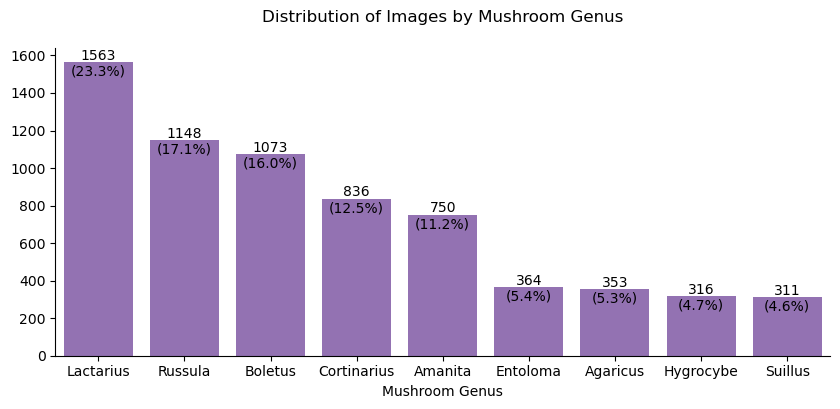

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
sns.countplot(x=images_df["label"], ax=ax, order=images_df["label"].value_counts().index, color='tab:purple')

total = len(images_df)
for p in ax.patches:
    count = p.get_height()
    percentage = (p.get_height() / total) * 100
    ax.annotate(f'{count:.0f}\n({percentage:.1f}%)', (p.get_x() + p.get_width()/2, p.get_height()),
                ha='center', va='center', xytext=(0, -1), textcoords='offset points')

ax.set(ylabel="", xlabel="Mushroom Genus", title="Distribution of Images by Mushroom Genus\n")
sns.despine()

As exposed above, class imbalance is presented, with most of the samples belonging to classed Lactarius, Russula and Boletus.

Let's show 1 image in each group to get an idea of what they look like. I will be sending to the bellow function 1 sample of each group of genus.

In [6]:
def read_images(image_paths):
    images_raw = []
    for path in image_paths:
        img = Image.open(path)
        images_raw.append(img)
    return images_raw

random_rows = images_df.groupby("label").sample(1)
images = pd.DataFrame({"images": read_images(random_rows["path"])})
images["label"] = [title for title in set(images_df["label"])]

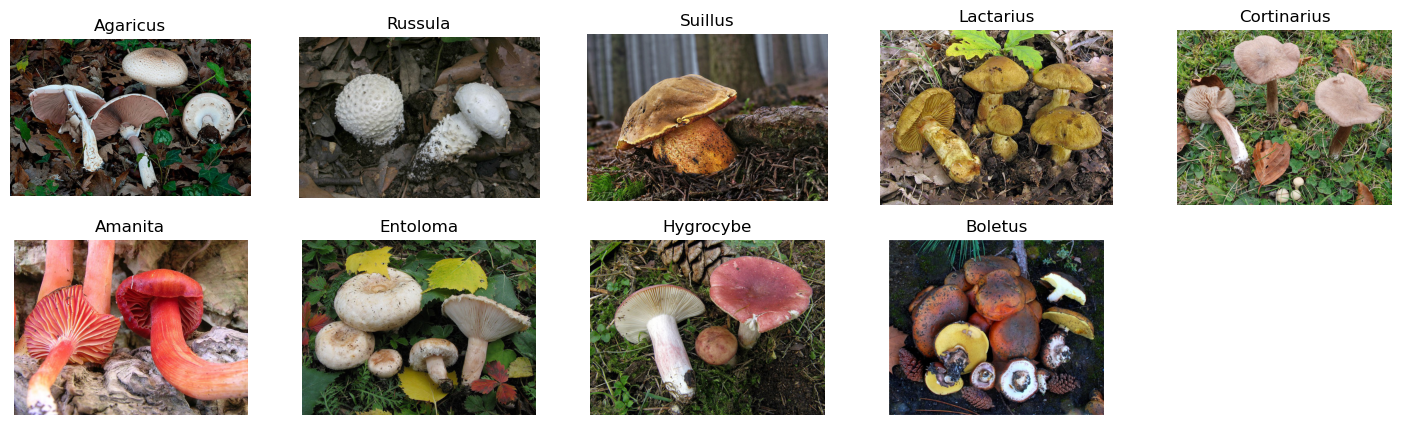

In [7]:
fig, axs = plt.subplots(2, 5, figsize=(18, 5))
axs = axs.flatten()

for ax, (img, label) in zip(axs, zip(images["images"], images["label"])):
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(label, fontsize=12, y=1)
plt.delaxes(axs[-1])

The above images highlight already that they have **difference sizes**. We will be making the proper **transformations to adapt to our base model** in the transfer learning. Let's take an overrall look at the size of all the pictures.

<h2 style="color:#774CAD">Distribution of Image Sizes</h2>

In [8]:
read_images_df = pd.DataFrame({"images": read_images(images_df["path"])})
read_images_df["label"] = images_df["label"]

width_list = []
height_list = []

for row in read_images_df["images"]:
    width, height = row.size
    width_list.append(width)
    height_list.append(height)

read_images_df["Width"], read_images_df["Height"] = width_list, height_list
read_images_df.head(5)

,images,label,Width,Height
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Agaricus,778,600
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Agaricus,700,525
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Agaricus,700,524
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Agaricus,800,600
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Agaricus,750,563


In [9]:
read_images_df.describe().round(2).loc[["mean", "min", "max"]]

,Width,Height
mean,796.18,579.81
min,259.00,152.00
max,1280.00,1024.00


As we can see, the **images sizes are very different**, varying from a possible minimal picture of 259 x 152, until 1280 x 1024.

The scatterplot bellow highlights however that the images tend to grow in both dimensions proportionally, and that many of them are close to a quadratic shape (graph main diagonal).

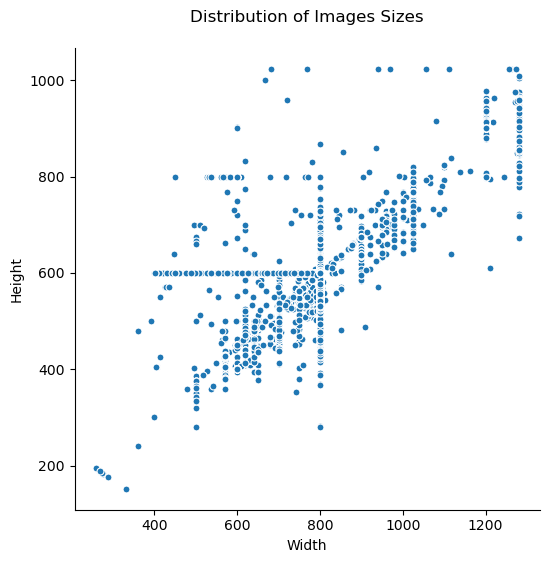

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.scatterplot(x=read_images_df["Width"], y=read_images_df["Height"], s=100, marker=".")
ax.set(title="Distribution of Images Sizes\n")
sns.despine()

<h2 style="color:#774CAD">Image Color Channels</h2>

We start this section by reading the number of channels in all the images and checking if any image has a number of channels different than 3.

In [11]:
def get_number_channels(df):
    number_channels = []

    for img in df["images"]:
        number_channels.append(len(np.array(img).shape))

    return number_channels

read_images_df["number_channels"] = get_number_channels(read_images_df)

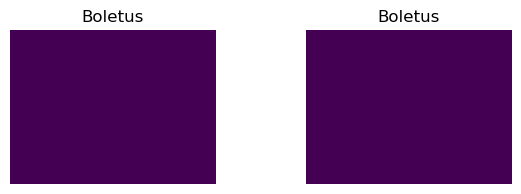

In [12]:
bad_images = read_images_df[read_images_df["number_channels"] != 3]
bad_images_idx = bad_images.index

fig, axs = plt.subplots(1, 2, figsize=(7, 2))
axs = axs.flatten()

for ax, (img, label) in zip(axs, zip(bad_images["images"], bad_images["label"])):
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(label, fontsize=12, y=1)

In [13]:
read_images_df = read_images_df.drop(bad_images_idx).reset_index().iloc[:,1:]

As returned above, there are **2 pictures** belonging to the genus Boletus that are **completely white**, their indices were stored and they will not be passed onto the model.

By looking at **duplicates**, I tried first to check every **numpy array**. This process was taking too long. An alternative process was carried out by **computing each image hash**. Perceptual hashing is the use of a fingerprinting algorithm that produces a snippet, hash, or fingerprint of various forms of multimedia.

In [14]:
read_images_df["hash"] = read_images_df["images"].apply(lambda x: str(imagehash.phash(x)))

In [15]:
hash_counts = read_images_df["hash"].value_counts().reset_index()
hash_counts.columns = ["hash", "hash_count"]
read_images_df = pd.merge(read_images_df, hash_counts, on="hash", how="left")
dupli_images = read_images_df[read_images_df["hash_count"] > 1]
dupli_images.shape

(152, 7)

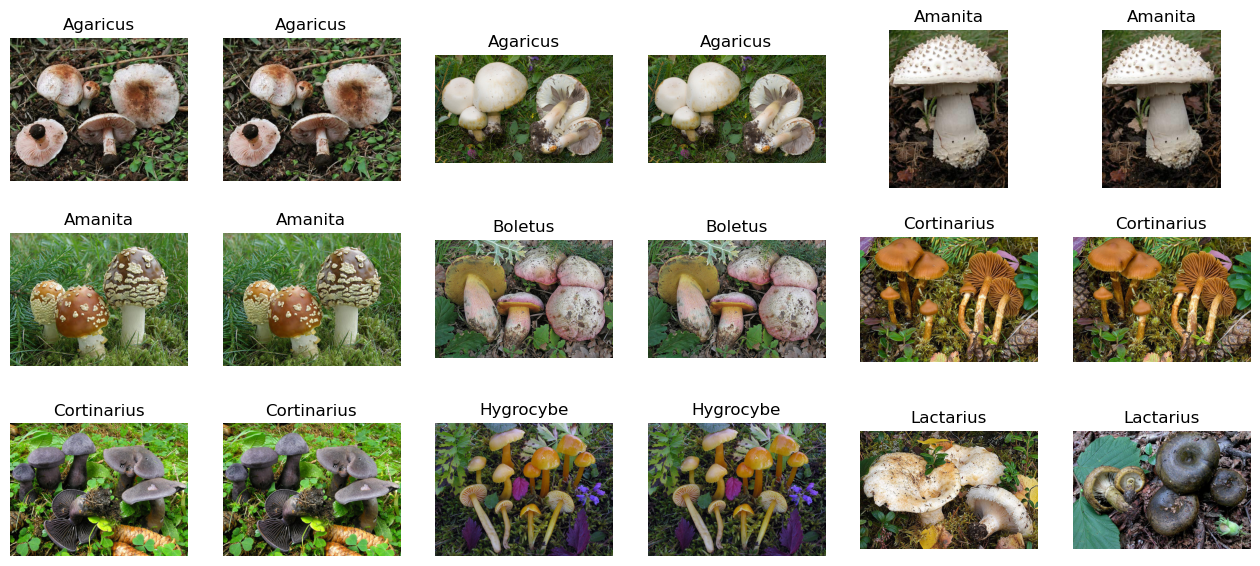

In [16]:
fig, axs = plt.subplots(3, 6, figsize=(16, 7))
axs = axs.flatten()

for ax, (img, label) in zip(axs, zip(dupli_images["images"][:30], dupli_images["label"][:30])):
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(label, fontsize=12, y=1)

In [17]:
dupli_images_idx =  dupli_images.drop_duplicates(subset="hash").index
read_images_df = read_images_df.drop_duplicates(subset="hash").reset_index().iloc[:,1:]
read_images_df.shape

(6636, 7)

As we can see, there are **152 images in the group of duplicates**, only the first of them will be kept in the model evaluation (76 will be dropped). 

We will now check the **average color in each channel** for all the images.

In [18]:
def get_avg_color_per_channel(df):
    red_list = []
    blue_list = []
    green_list = []

    for img in df["images"]:
        red = np.array(img)[:, :, 0].mean() / 255
        blue = np.array(img)[:, :, 1].mean() / 255
        green = np.array(img)[:, :, 2].mean() / 255
        red_list.append(red)
        blue_list.append(blue)
        green_list.append(green)

    return red_list, blue_list, green_list

read_images_df["Red"], read_images_df["Blue"], read_images_df["Green"] = get_avg_color_per_channel(read_images_df)

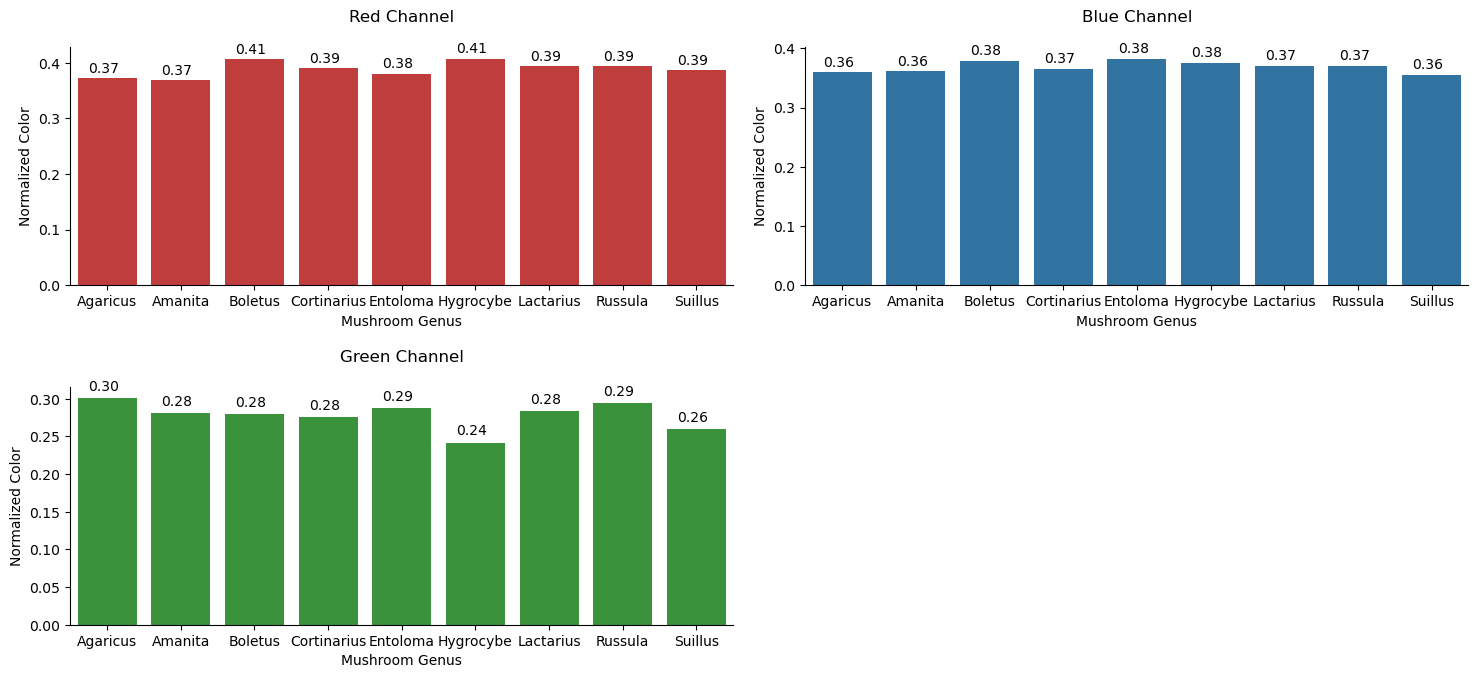

In [19]:
color_channels = read_images_df[['label','Red', 'Blue', 'Green']].groupby("label").mean()
color = ["tab:red", "tab:blue", "tab:green"]

fig, axs = plt.subplots(2, 2, figsize=(15, 7))
axs = axs.flatten()

for i, col in enumerate(color_channels):
    sns.barplot(x=color_channels.index, y=color_channels[col], ax=axs[i], color=color[i])
    axs[i].set(ylabel="Normalized Color", xlabel="Mushroom Genus", title=f"{col} Channel\n")

    for bar, val in zip(axs[i].patches, color_channels[col]):
        axs[i].text(bar.get_x() + bar.get_width() / 2 - 0.05, bar.get_height() + 0.01, f'{val:.2f}', ha='center')

plt.delaxes(axs[-1])
plt.tight_layout(pad=1.5)
sns.despine()

The plotted graph gives us an **idea of the colors that are more present in each of the genus**. We can see that the green channel tend to have more darker tones than the blue and red (values closer to 0). Just based on these average values, the Boletus group seems to have the most light pictures. Hygrocybe also sees to present light values, except for its green channel.

Here, some **statistical evaluations could be carried out** to check the affirmations above and also if there are significant differences between these groups. Not in the scope of this project.

In [20]:
# pd.DataFrame(bad_images_idx).to_csv("export/bad_images_idx.csv", sep=";", index=False)
# pd.DataFrame(dupli_images_idx).to_csv("export/dupli_images_idx.csv", sep=";", index=False)

Due to the time contraints to run this EDA, the model section is divided in another notebook.